## 分类面采样以对ROC上采样点做估计

对于多元正态分布，用理论公式的方式(多重积分)去计算错误率是很困难的，所以绘制ROC曲线时，我采用改变分类面，获得多个采样分类面，在采样分类面上用频率估计错误率。

改变采样分类面的方式可以改变分类面的常数阈值，即把0改成一定区间上的正负值b：

gi(x)-gj(x)=b

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 绘制3D坐标的函数
import numpy as np
import math

求二元正态分布概率密度函数值

In [3]:
def gauss2(x, miu, sgm):
    r = np.mat([x[0]-miu[0], x[1]-miu[1]])
    multi = r * sgm.I * r.T
    multi = float(multi)  # 1乘1矩阵取内容 I求逆,.T转置
    k = np.exp(-multi / 2)
    k /= 2 * np.math.pi *(abs( np.linalg.det(sgm)) ** (1 / 2) ) # linalg.det求行列式的值
    return k

In [4]:
def getData():
    fr1=open(r'boynew.txt')
    fr0=open(r'girlnew.txt')
    arrayOLines1 = fr1.readlines()  # 读取文件
    arrayOLines0 = fr0.readlines()
    dataMat1 = []
    dataMat0 = []
    for line in arrayOLines1:
        line = line.strip()  # strip()去掉首尾空格
        listFromLine = line.split()
        for i in range(len(listFromLine)):
            listFromLine[i] = float(listFromLine[i])
        dataMat1.append(listFromLine)
    for line in arrayOLines0:
        line = line.strip()  # strip()去掉首尾空格
        listFromLine = line.split()
        for i in range(len(listFromLine)):
            listFromLine[i] = float(listFromLine[i])
        dataMat0.append(listFromLine)
    return dataMat1, dataMat0

In [5]:
def TraBys(i, j):
    dataMat1, dataMat0 = getData()
    dataMat1 = np.mat(dataMat1)
    dataMat0 = np.mat(dataMat0)

    miu1, miu0, sgm1, sgm0 = getMiuSgm(i, j, dataMat1, dataMat0)
    return miu1, miu0, sgm1, sgm0

In [6]:
def rebuidx(x, ranges, minVals):
    return (x - minVals) / ranges
def autoNorm(dataMat):
    # 可以将不同取值范围的特征值数值归一化到0~1之间
    minVals = dataMat.min(0)
    maxVals = dataMat.max(0)
    ranges = maxVals - minVals
    newDataMat = np.zeros(np.shape(dataMat))
    m = dataMat.shape[0]
    newDataMat = dataMat - np.tile(minVals, (m, 1))
    newDataMat = newDataMat / np.tile(ranges, (m, 1))
    return newDataMat, ranges, minVals  # 返回归一化之后的矩阵,原范围,原最小值
def getMiuSgm(i, j, dataMat1, dataMat0):
    Imiu1 = 0.0
    for r in range(len(dataMat1)):
        Imiu1 += dataMat1[r, i]
    Imiu1 = Imiu1 / len(dataMat1)
    Imiu0 = 0.0
    for r in range(len(dataMat0)):
        Imiu0 += dataMat0[r, i]
    Imiu0 = Imiu0 / len(dataMat0)
    Jmiu1 = 0.0
    for r in range(len(dataMat1)):
        Jmiu1 += dataMat1[r, j]
    Jmiu1 = Jmiu1 / len(dataMat1)
    Jmiu0 = 0.0
    for r in range(len(dataMat0)):
        Jmiu0 += dataMat0[r, j]
    Jmiu0 = Jmiu0 / len(dataMat0)
    miu1 = [Imiu1, Jmiu1]
    miu0 = [Imiu0, Jmiu0]

    sgm1 = np.mat(np.zeros((2, 2)))
    for k in range(len(dataMat1)):
        x = np.mat([dataMat1[k, i] - miu1[0], dataMat1[k, j] - miu1[1]])
        sgm1 += x.T * x
    sgm1 /= len(dataMat1)

    sgm0 = np.mat(np.zeros((2, 2)))
    for k in range(len(dataMat0)):
        x = np.mat([dataMat0[k, i] - miu0[0], dataMat0[k, j] - miu0[1]])
        sgm0 += x.T * x
    sgm0 /= len(dataMat0)
    return miu1, miu0, sgm1, sgm0# 返回两均值,两方差

In [7]:
def show(i,j,miu1,miu0,sgm1,sgm0):
    # 采样间距
    if i == 0:  # 如果特征i是身高,那么采样区间是140~200
        Ilft = 140
        Irgt = 200
        xlab = 'Height'
    elif i == 1:  # 如果特征i是体重,那么采样区间是30~80
        Ilft = 30
        Irgt = 80
        xlab = 'Weight'
    else:  # 如果特征i是鞋码,那么采样区间是32~46
        Ilft = 32
        Irgt = 46
        xlab = 'Shoe Size'
    if j == 0:
        Jlft = 140
        Jrgt = 200
        ylab = 'Height'
    elif j == 1:
        Jlft = 30
        Jrgt = 80
        ylab = 'Weight'
    else:
        Jlft = 32
        Jrgt = 46
        ylab = 'Shoe Size'
    # linspace创建等差数列,在I/J方向上取采样点
    I1 = np.linspace(Ilft, Irgt, 50)
    J1 = np.linspace(Jlft, Jrgt, 50)
    I0 = np.linspace(Ilft, Irgt, 50)
    J0 = np.linspace(Jlft, Jrgt, 50)
    # 映射以扩充为二维采样面上的点
    X1, Y1 = np.meshgrid(I1, J1)
    X0, Y0 = np.meshgrid(I0, J0)
    # 用正态分布概率密度函数得到采样点的Z值序列
    Z1 = []
    for k in range(len(J1)):
        for p in range(len(I1)):
            Z1.append(gauss2([X1[k][p], Y1[k][p]], miu1, sgm1))
    Z1 = np.reshape(Z1, (len(J1), len(I1)))
    Z0 = []
    for k in range(len(J0)):
        for p in range(len(I0)):
            Z0.append(gauss2([X0[k][p], Y0[k][p]], miu0, sgm0))
    Z0 = np.reshape(Z0, (len(J0), len(I0)))
    fig1 = plt.figure()  # 创建一个绘图对象
    ax = Axes3D(fig1)
    # 条件概率密度函数

    ax.plot_surface(np.array(X1), np.array(Y1), Z1, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.plot_surface(np.array(X0), np.array(Y0), Z0, rstride=1, cstride=1, cmap=plt.cm.jet)
    plt.title("The probability density function of the class condition")
    ax.set_xlabel(xlab, color='r')
    ax.set_ylabel(ylab, color='g')
    ax.set_zlabel('Probability Density', color='b')
    plt.show()

In [8]:
def Wi(sgm):  # 计算dxd矩阵(二次项携带矩阵)
    return (-1/2)*sgm.I


def wi(miu, sgm):  # 计算d维列向量(一次项系数矩阵)
    return sgm.I*miu.T


def omgi(miu, sgm, Ppre):  # 计算常数项,还要传入先验概率
    return float((-1 / 2) * miu * sgm.I * miu.T) - \
           (1 / 2) * np.log(np.linalg.det(sgm)) + \
           np.log(Ppre)

In [9]:
def newgx(miu1,miu0,sgm1,sgm0,x):
    # 新的计算判别函数的方式
    # 因为先验概率都是0.5,不妨去掉这一项,然后乘以系数-2作反向判别
    # 暂存第一项
    s1 = (x - miu1) * sgm1.I * (x - miu1).T
    s0 = (x - miu0) * sgm0.I * (x - miu0).T
    # 取矩阵内容
    s1 = float(s1)
    s0 = float(s0)
    # 求出两个反向判别gx
    rvs_g1x = s1 + np.log(abs(np.linalg.det(sgm1)))
    rvs_g0x = s0 + np.log(abs(np.linalg.det(sgm0)))
    # 因为反向判别,所以反向返回
    return rvs_g0x, rvs_g1x

In [10]:
def TstBys(miu1,miu0,sgm1,sgm0,x,b=0):
    # 列表变矩阵,否则不能转置
    x = np.mat(x)
    miu1 = np.mat(miu1)
    miu0 = np.mat(miu0)
    g1x, g0x = newgx(miu1, miu0, sgm1, sgm0, x)
    if g1x - g0x > b:
        return 1
    else:
        return 0

In [11]:
def errTst(i,j):
    fr1=open(r'boy.txt') #测试集
    fr0=open(r'girl.txt')
    arrayOLines1 = fr1.readlines()  # 读取文件
    arrayOLines0 = fr0.readlines()
    # 特征矩阵
    dataMat = []
    labelVec = []
    for line in arrayOLines1:
        line = line.strip()  # strip()去掉首尾空格
        listFromLine = line.split()
        for r in range(len(listFromLine)):
            listFromLine[r] = float(listFromLine[r])
        dataMat.append(listFromLine)
        labelVec.append(1)
    for line in arrayOLines0:
        line = line.strip()
        listFromLine = line.split()
        for r in range(len(listFromLine)):
            listFromLine[r] = float(listFromLine[r])
        dataMat.append(listFromLine)
        labelVec.append(0)
    errCount = 0.0  # 错误分类次数计数
    # 极大似然法训练出四个参数(两均值,两协方差矩阵)
    miu1, miu0, sgm1, sgm0 = TraBys(i, j)
    for k in range(len(labelVec)):
        x = [dataMat[k][i], dataMat[k][j]]
        if TstBys(miu1, miu0, sgm1, sgm0, x, 0) != labelVec[k]:
            errCount += 1  # 记录分类错误
    print("error rate:", errCount / len(labelVec))
    return dataMat, labelVec  # 返回测试集,用来求后面的两类错误率

对于传入的b值,改变超平面的位置

从而获取假阳性率(误识率)和召回率(1-拒识率)

假设1男性为阳性,0女性为阴性

用测试集做错误率测试,传入特征号i和j

In [12]:
def getROCxy(dataMat, labelVec, i, j, b):
    FPR=0.0  # 假阳性数->率
    RECALL=0.0  # 召回数->率
    FPplusTN = 0.0  # 存阴性样本数
    TPplusFN = 0.0  # 存阳性样本数
    # 极大似然法训练出四个参数(两均值,两协方差矩阵)
    miu1, miu0, sgm1, sgm0= TraBys(i, j)
    for k in range(len(labelVec)):
        x = [float(dataMat[k][i]), float(dataMat[k][j])]  # 特征矩阵第k行的第[i,j]号特征向量做测试
        yc = TstBys(miu1, miu0, sgm1, sgm0, x, b)  # 本次预测出来的类号
        if labelVec[k] == 1:
            TPplusFN += 1
        else:
            FPplusTN += 1
        if labelVec[k] == 1 and yc == 1:
            RECALL += 1
        # 阴性样本 && 预测为阳性
        elif labelVec[k] == 0 and yc == 1:
            FPR += 1
    # 假阳性率
    FPR /= FPplusTN
    # 召回(真阳性)率
    RECALL /= TPplusFN
    return FPR, RECALL

In [19]:
def Go(i, j):  # 演示用的函数,传入两个特征编号i和j
    miu1, miu0, sgm1, sgm0=TraBys(i,j)
    show(i, j, miu1, miu0, sgm1, sgm0)
    dataMat, labelVec = errTst(i, j)
    print('ROC:')
    X = []
    Y = []
    # 分类面采样阈值从-50到60,每次移动1
    for b in range(-50, 60, 1):
        # 获取假阳率和真阳率
        FPR, RECALL = getROCxy(dataMat, labelVec, i, j, b)
        # 分别加入到坐标采样列表中
        X.append(FPR)
        Y.append(RECALL)
    # 绘制ROC曲线
    plt.plot(X, Y, "g-", linewidth=2)
    plt.xlabel('FPR')
    plt.ylabel('RECALL')
    if i == 0:
        xlab = 'Height'
    elif i == 1:
        xlab = 'Weight'
    else:
        xlab = 'Shoe Size'
    if j == 0:
        ylab = 'Height'
    elif j == 1:
        ylab = 'Weight'
    else:
        ylab = 'Shoe Size'
    plt.title('ROC curve (if use ' + xlab + ' and ' + ylab + ' as feature)')
    plt.grid(True)
    x4 = np.linspace(0, 1, 1000)
    y4 = np.linspace(0, 1, 1000)
    plt.plot(x4, y4, linestyle='--')
    plt.show()

    sample_height = np.linspace(30,50, 100)
    sample_weight = np.linspace(140, 200, 100)
    # 将原始数据变成网格数据
    Sample_height, Sample_weight = np.meshgrid(sample_height, sample_weight)
    # 填充颜色
    plt.contourf(Sample_height, Sample_weight, f(Sample_height, Sample_weight,miu1,miu0,sgm1,sgm0), 0, alpha=0)
    # 绘制等高线,圈内为女生，圈外为男生
    C = plt.contour(Sample_height, Sample_weight, f(Sample_height, Sample_weight,miu1,miu0,sgm1,sgm0), 0, colors='black', linewidths=0.6)
    # 显示各等高线的数据标签
    plt.clabel(C, inline=True, fontsize=10)
    dataMat1, dataMat0 = getData()
    dataMat1 = np.mat(dataMat1)
    dataMat0 = np.mat(dataMat0)
    man_height = list(dataMat1[:, i])
    man_weight = list(dataMat1[:, j])
    woman_height = list(dataMat0[:, i])
    woman_weight = list(dataMat0[:, j])
    p1 = plt.scatter(man_height, man_weight, c='g', marker='*', linewidths=0.4)
    p2 = plt.scatter(woman_height, woman_weight, c='r', marker='*', linewidths=0.4)
    label = ['boy', 'girl']
    plt.legend([p1, p2], label, loc=0)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [13]:
def f(sample_height, sample_weight,miu1,miu0,sgm1,sgm0):
    mytemp1 = np.zeros(shape=(100, 100))
    dettemp=(np.linalg.det(sgm0)) / (np.linalg.det(sgm1))
    sample_vector = np.matrix([[sample_height[0, 0]], [sample_weight[0, 0]]]).T
    for i in range(100):
        for j in range(100):
            sample_vector = np.matrix([[sample_height[i, j]], [sample_weight[i, j]]])
            sample_vector_T = np.transpose(sample_vector)
            # 定义决策函数
            mytemp1[i, j] =0.5 * (sample_vector_T- miu0) * (np.linalg.inv(sgm0)) * \
                np.transpose(sample_vector_T - miu0) - 0.5 * (sample_vector_T - miu1) * \
                (np.linalg.inv(sgm1)) * np.transpose(sample_vector_T - miu1) + 0.5 * math.log(dettemp)
    return mytemp1

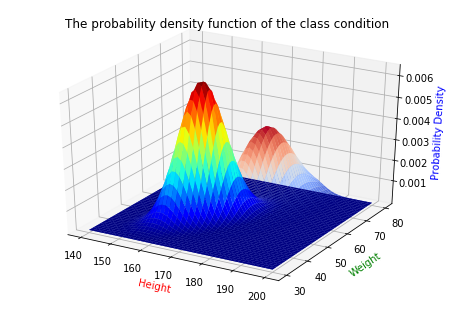

error rate: 0.14049586776859505
ROC:


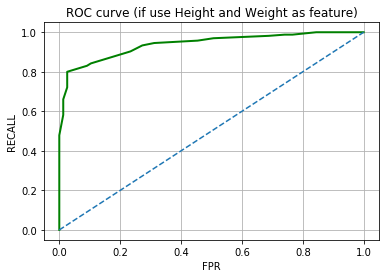

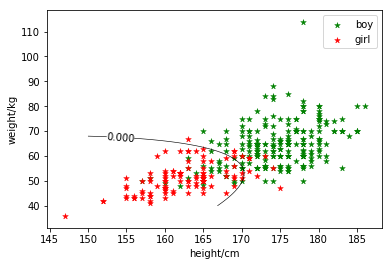

In [15]:
Go(0,1)

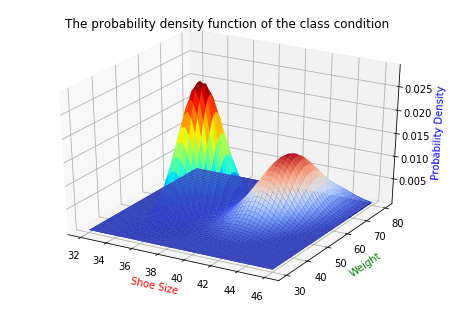

error rate: 0.049586776859504134
ROC:


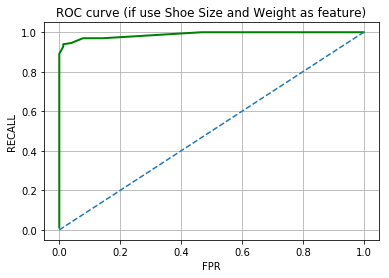

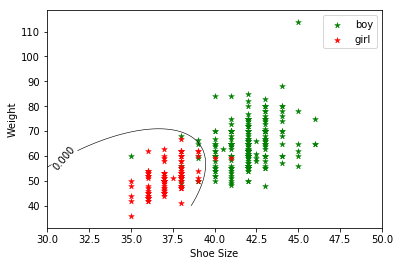

In [18]:
Go(2,1)

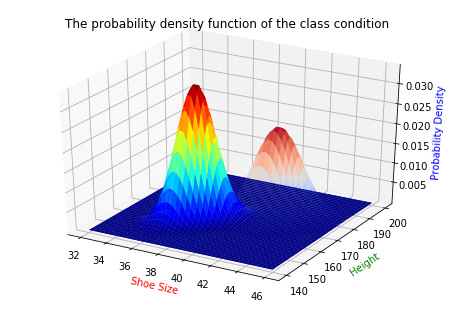

error rate: 0.05371900826446281
ROC:


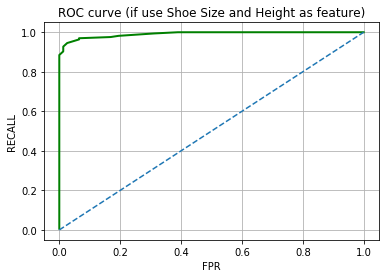

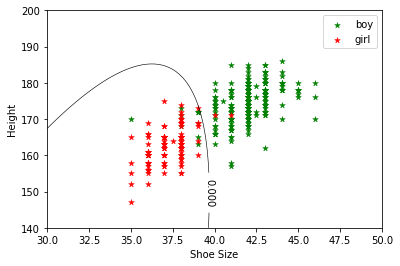

In [20]:
Go(2,0)